# Testing ClusterDE

In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

import os
# os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
# import pertpy as pt
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

In [2]:
import importlib

## Preprocessing
### Read data

In [3]:
data_path = "../../data/MOBA_scRNAseq/outs_S3"
data_all = sc.read_10x_h5(data_path + "/filtered_feature_bc_matrix.h5")
data_all

AnnData object with n_obs × n_vars = 1652 × 21982
    var: 'gene_ids', 'feature_types', 'genome'

### Aggregate probes through max-pooling

In [4]:
data_maxpool = up.prep_probe_BacSC_data(data_all, agg_fn=np.max)
sc.pp.calculate_qc_metrics(data_maxpool, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_maxpool

Aggregating feature 100/5572
Aggregating feature 200/5572
Aggregating feature 300/5572
Aggregating feature 400/5572
Aggregating feature 500/5572
Aggregating feature 600/5572
Aggregating feature 700/5572
Aggregating feature 800/5572
Aggregating feature 900/5572
Aggregating feature 1000/5572
Aggregating feature 1100/5572
Aggregating feature 1200/5572
Aggregating feature 1300/5572
Aggregating feature 1400/5572
Aggregating feature 1500/5572
Aggregating feature 1600/5572
Aggregating feature 1700/5572
Aggregating feature 1800/5572
Aggregating feature 1900/5572
Aggregating feature 2000/5572
Aggregating feature 2100/5572
Aggregating feature 2200/5572
Aggregating feature 2300/5572
Aggregating feature 2400/5572
Aggregating feature 2500/5572
Aggregating feature 2600/5572
Aggregating feature 2700/5572
Aggregating feature 2800/5572
Aggregating feature 2900/5572
Aggregating feature 3000/5572
Aggregating feature 3100/5572
Aggregating feature 3200/5572
Aggregating feature 3300/5572
Aggregating feature

AnnData object with n_obs × n_vars = 1652 × 5572
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [5]:
print(f"Zero inflation of probe-wise data: {((np.prod(data_all.X.shape) - data_all.X.getnnz()) / np.prod(data_all.X.shape)).round(3)}")
print(f"Zero inflation of aggregated data: {((np.prod(data_maxpool.X.shape) - data_maxpool.X.getnnz()) / np.prod(data_maxpool.X.shape)).round(3)}")


Zero inflation of probe-wise data: 0.936
Zero inflation of aggregated data: 0.831


### Filter cells

--> filter baased on mean absolute standard deviation

In [6]:
importlib.reload(ut)
data_gene = ut.filter_outliers(data_maxpool, nmads=5, min_cells=2)
print(data_maxpool.obs.outlier.value_counts())
print(f"Total number of cells: {data_maxpool.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

outlier
False    1544
True      108
Name: count, dtype: int64
Total number of cells: 1652
Number of cells after filtering: 1544


AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [7]:
data_gene.layers["counts"] = data_gene.X.copy()

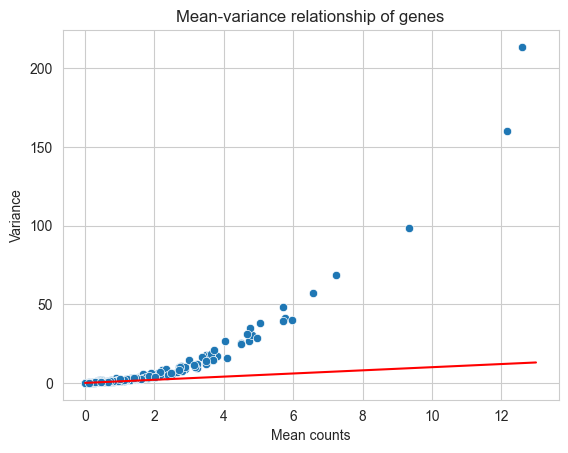

In [8]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

## Estimate negative binomial parameters for each gene

In [9]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts")

In [10]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [11]:
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)
data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
data_gene.layers["vst_counts"] = data_gene.X.copy()
sc.pp.scale(data_gene, max_value=10, zero_center=True)
# data_gene.X[np.isnan(data_gene.X)] = 0
sc.tl.pca(data_gene, svd_solver='arpack')

## Count-splitting into train and test data

In [12]:
data_train, data_test = cs.countsplit_adata(data_gene, data_dist="NB", beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

AnnData object with n_obs × n_vars = 1544 × 5511
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'mean', 'std'
    layers: 'counts'


In [13]:
# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_test.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

## PCA, embedding and clustering

In [14]:
k_opt = 3
n_neighbors_opt = 200
min_dist_opt = 0.1
res_opt = 0.31

In [15]:
sc.pp.neighbors(data_gene, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_gene, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


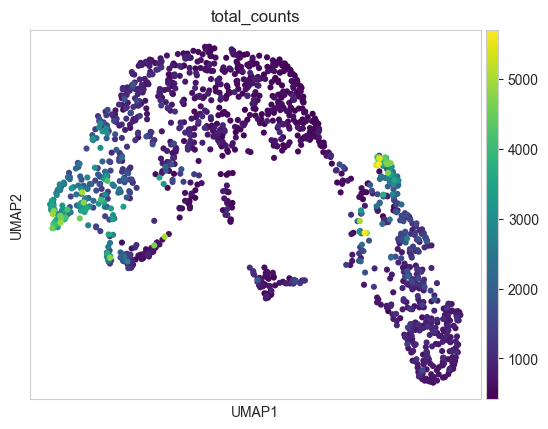

In [16]:
sc.pl.umap(data_gene, color="total_counts", alpha=1, cmap="viridis")
plt.show()

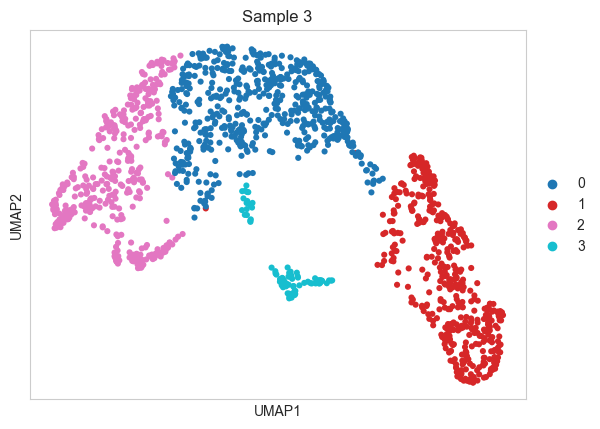

In [17]:
sc.tl.leiden(data_gene, resolution=res_opt, key_added="leiden_opt", random_state=1234)
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

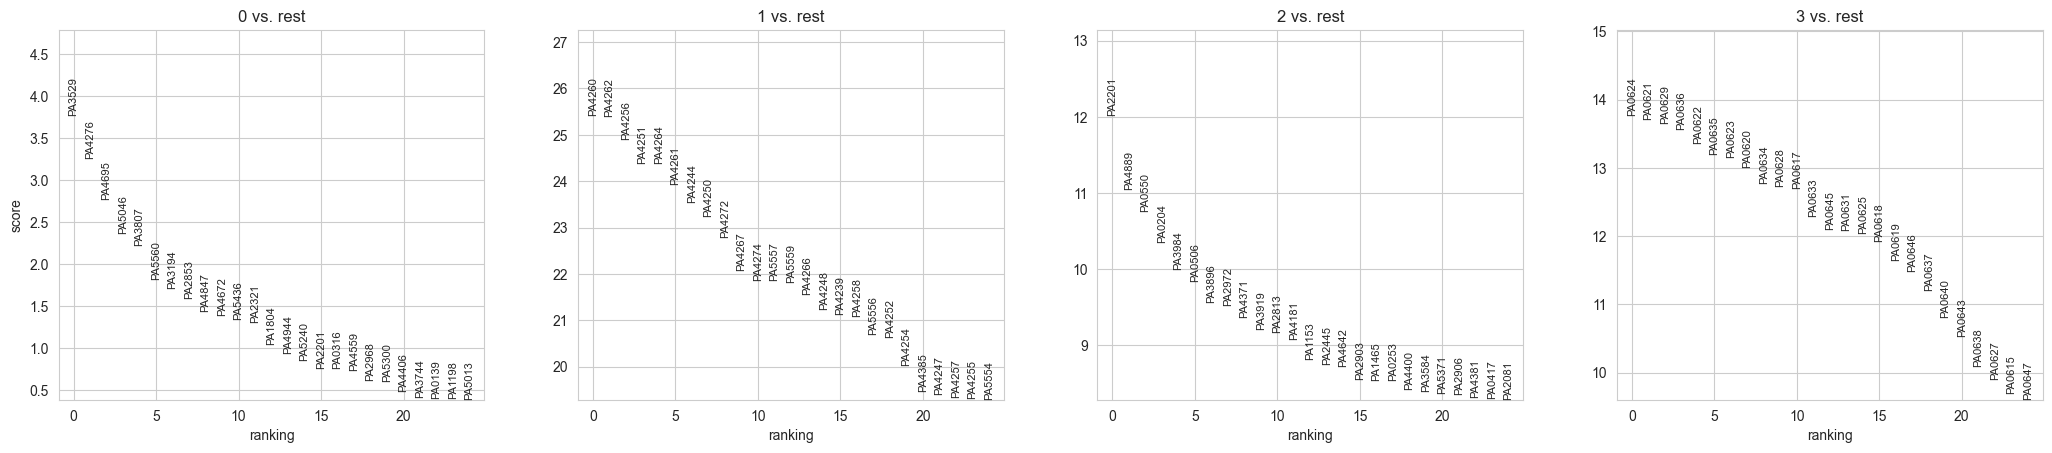

In [18]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

In [19]:
data_gene.obs["is_cluster_3"] = ([x == "3" for x in data_gene.obs["leiden_opt"]])
data_gene.obs["is_cluster_3"] = data_gene.obs["is_cluster_3"].astype("category")
data_gene.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,outlier,n_genes,leiden_opt,is_cluster_3
AAACCCAGTGGACCTC-1,395,5.981414,485.0,6.186209,False,395,0,False
AAACCCATCCTGTAGA-1,558,6.326149,863.0,6.761573,False,558,1,False
AAACGCTCAGATTTCG-1,398,5.988961,491.0,6.198479,False,398,0,False
AAACGCTTCTTTGCTA-1,598,6.395262,1013.0,6.921658,False,598,1,False
AAAGAACCAGTCTGGC-1,897,6.800170,1190.0,7.082549,False,897,2,False
...,...,...,...,...,...,...,...,...
TTTGATCTCCTCGCAT-1,592,6.385194,924.0,6.829794,False,592,1,False
TTTGGAGCACCGAATT-1,1930,7.565793,5446.0,8.602820,False,1930,1,False
TTTGGAGCAGCAGTTT-1,604,6.405228,748.0,6.618739,False,604,2,False
TTTGGTTTCGTTGTGA-1,371,5.918894,470.0,6.154858,False,371,1,False


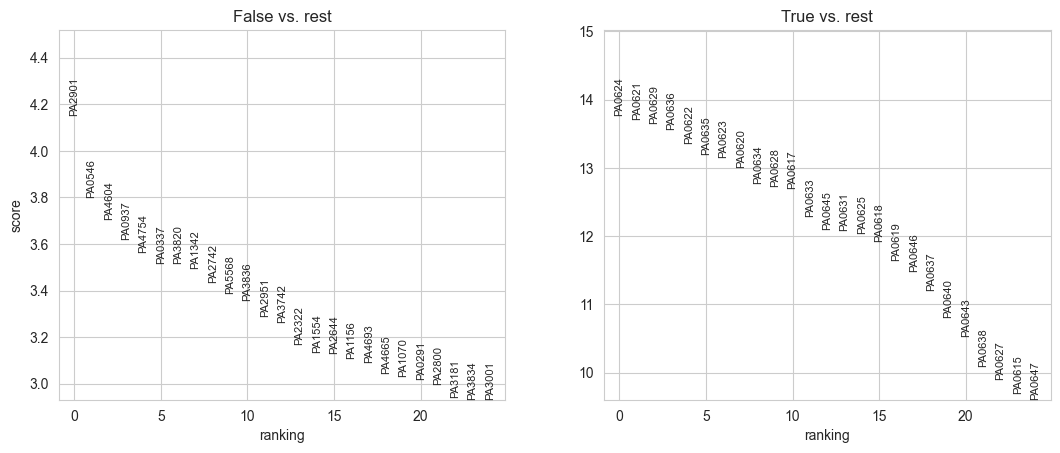

In [20]:
sc.tl.rank_genes_groups(data_gene, 'is_cluster_3', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

In [21]:
data_gene.var

,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,nb_overdisp,nb_overdisp_cutoff,nb_mean,mean,std
PA0001,Gene Expression,PA01,735,0.666451,0.510696,52.396373,1029.0,6.937314,735,0.755973,18.101791,18.101791,-7.136661,1.601061,0.118592
PA0002,Gene Expression,PA01,541,0.468912,0.384522,64.961140,724.0,6.586172,541,0.588412,12.567839,12.567839,-7.722425,1.230998,0.142648
PA0003,Gene Expression,PA01,890,0.893782,0.638576,42.357513,1380.0,7.230563,890,1.043122,19.421453,19.421453,-6.717806,1.694127,0.124373
PA0004,Gene Expression,PA01,463,0.373705,0.317511,70.012953,577.0,6.359574,463,0.398557,9.869301,9.869301,-8.054853,0.984926,0.149049
PA0005,Gene Expression,PA01,173,0.120466,0.113745,88.795337,186.0,5.231109,173,0.124089,2.334617,2.334617,-9.840559,-0.458170,0.254975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA5566,Gene Expression,PA01,14,0.009715,0.009668,99.093264,15.0,2.772589,14,0.010916,0.120941,0.120941,-12.010186,-3.469764,0.312612
PA5567,Gene Expression,PA01,163,0.126943,0.119509,89.443005,196.0,5.283204,163,0.161347,2.350899,2.350899,-9.833309,-0.449967,0.267776
PA5568,Gene Expression,PA01,740,0.659974,0.506802,52.072539,1019.0,6.927558,740,0.750315,18.045025,18.045025,-7.143407,1.597250,0.118606
PA5569,Gene Expression,PA01,1430,3.498057,1.503646,7.383420,5401.0,8.594525,1430,14.170981,6.439472,6.439472,-5.552675,1.302479,0.373983


In [22]:
count_mat = data_gene.X.copy()

In [23]:
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources'
r_path = "/Library/Frameworks/R.framework/Resources/bin"
os.environ["PATH"] = r_path + ";" + os.environ["PATH"]

import rpy2.robjects as rp
from rpy2.robjects import numpy2ri, pandas2ri
numpy2ri.activate()
pandas2ri.activate()
import rpy2.robjects.packages as rpackages

In [24]:
Seurat = rpackages.importr("Seurat")
SingleCellExperiment = rpackages.importr("SingleCellExperiment")
SummarizedExperiment = rpackages.importr("SummarizedExperiment")
ClusterDE = rpackages.importr("ClusterDE")
scDesign3 = rpackages.importr("scDesign3")
anndata = rpackages.importr("anndata")
SeuratDisk = rpackages.importr("SeuratDisk")

base = rpackages.importr('base')
set_column = getattr(base, '$<-')


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [25]:
data_gene2 = ad.AnnData(X = data_gene.layers["counts"].toarray(), obs=data_gene.obs, var=data_gene.var)
data_gene2

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'leiden_opt', 'is_cluster_3'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'mean', 'std'

In [26]:
data_gene2.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,outlier,n_genes,leiden_opt,is_cluster_3
AAACCCAGTGGACCTC-1,395,5.981414,485.0,6.186209,False,395,0,False
AAACCCATCCTGTAGA-1,558,6.326149,863.0,6.761573,False,558,1,False
AAACGCTCAGATTTCG-1,398,5.988961,491.0,6.198479,False,398,0,False
AAACGCTTCTTTGCTA-1,598,6.395262,1013.0,6.921658,False,598,1,False
AAAGAACCAGTCTGGC-1,897,6.800170,1190.0,7.082549,False,897,2,False
...,...,...,...,...,...,...,...,...
TTTGATCTCCTCGCAT-1,592,6.385194,924.0,6.829794,False,592,1,False
TTTGGAGCACCGAATT-1,1930,7.565793,5446.0,8.602820,False,1930,1,False
TTTGGAGCAGCAGTTT-1,604,6.405228,748.0,6.618739,False,604,2,False
TTTGGTTTCGTTGTGA-1,371,5.918894,470.0,6.154858,False,371,1,False


In [27]:
data_gene2.write(data_path + "/test_to_seurat.h5ad")

In [45]:
rp.r("library('Seurat')")
rp.r("library('anndata')")
rp.r("data <- read_h5ad('../../data/MOBA_scRNAseq/outs_S3/test_to_seurat.h5ad')")
# rp.r("print(data$var)")
rp.r("data <- CreateSeuratObject(counts = t(data$X), meta.data = data$obs)")
rp.r("print(data$RNA)")

Assay data with 5553 features for 1544 cells
First 10 features:
 PA0001, PA0002, PA0003, PA0004, PA0005, PA0006, PA0007, PA0008, PA0009,
PA0010 


In [29]:
rp.r("library('SummarizedExperiment')")
rp.r("library('SingleCellExperiment')")
rp.r("mat <- GetAssayData(object = data, slot = 'counts')")
rp.r("sce <- SingleCellExperiment::SingleCellExperiment(list(counts = mat))")
rp.r("SummarizedExperiment::colData(sce)$cell_type <- '1'")
sce = rp.r("sce")
print(sce)

class: SingleCellExperiment 
dim: 5553 1544 
metadata(0):
assays(1): counts
rownames(5553): PA0001 PA0002 ... PA5569 PA5570
rowData names(0):
colnames(1544): AAACCCAGTGGACCTC-1 AAACCCATCCTGTAGA-1 ...
  TTTGGTTTCGTTGTGA-1 TTTGTTGAGTAATACG-1
colData names(1): cell_type
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [30]:
rp.r("""
library(scDesign3)
newData <- scdesign3(
    sce,
    celltype = "cell_type",
    pseudotime = NULL,
    spatial = NULL,
    other_covariates = NULL,
    empirical_quantile = FALSE,
    mu_formula = "1",
    sigma_formula = "1",
    corr_formula = "1",
    family_use = "nb",
    nonzerovar = FALSE,
    n_cores = 1,
    parallelization = "pbmcmapply",
    important_feature = "auto",
    nonnegative = FALSE,
    copula = "gaussian",
    fastmvn = FALSE
)""")

R[write to console]: Input Data Construction Start

R[write to console]: Input Data Construction End

R[write to console]: Start Marginal Fitting



  |=======================================================| 100%, Elapsed 04:49


R[write to console]: Marginal Fitting End

R[write to console]: Start Copula Fitting

R[write to console]: Convert Residuals to Multivariate Gaussian



  |=======================================================| 100%, Elapsed 02:17


R[write to console]: Converting End

R[write to console]: Copula group 1 starts

R[write to console]: Copula Fitting End

R[write to console]: Start Parameter Extraction



  |=======================================================| 100%, Elapsed 08:09


R[write to console]: Parameter
Extraction End

R[write to console]: Start Generate New Data

R[write to console]: Use Copula to sample a multivariate quantile matrix

R[write to console]: Sample Copula group 1 starts



  |=======================================================| 100%, Elapsed 00:33


R[write to console]: New Data Generating End



In [98]:
rp.r(f"null_data <- CreateSeuratObject(counts = newData$new_count)")
rp.r("print(null_data$RNA)")
rp.r("library(SeuratDisk)")
rp.r("library(loomR)")
rp.r("print(null_data)")

rp.r("SaveH5Seurat(null_data, filename = '../../data/MOBA_scRNAseq/outs_S3/null_data.h5Seurat', overwrite=TRUE)")

Assay data with 5553 features for 1544 cells
First 10 features:
 PA0001, PA0002, PA0003, PA0004, PA0005, PA0006, PA0007, PA0008, PA0009,
PA0010 
An object of class Seurat 
5553 features across 1544 samples within 1 assay 
Active assay: RNA (5553 features, 0 variable features)


R[write to console]: Warning:
R[write to console]:  Overwriting previous file ../../data/MOBA_scRNAseq/outs_S3/null_data.h5Seurat

R[write to console]: Creating h5Seurat file for version 3.1.5.9900

R[write to console]: Adding counts for RNA

R[write to console]: Adding data for RNA

R[write to console]: No variable features found for RNA

R[write to console]: No feature-level metadata found for RNA



In [ ]:
data_null = ad.AnnData()

In [99]:
import anndata2ri
anndata2ri.activate()

#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

In [100]:
%%R
suppressPackageStartupMessages(library(Seurat))

# Load PBMC dataset from Seurat tutorial
data.null <- LoadH5Seurat("../../data/MOBA_scRNAseq/outs_S3/null_data.h5Seurat")
data.null

An object of class Seurat 
5553 features across 1544 samples within 1 assay 
Active assay: RNA (5553 features, 0 variable features)


Validating h5Seurat file
Initializing RNA with data
Adding counts for RNA
Adding miscellaneous information for RNA
Adding command information
Adding cell-level metadata
Adding miscellaneous information
Adding tool-specific results


In [101]:
%%R -o data_null
#convert the Seurat object to a SingleCellExperiment object
data_null <- as.SingleCellExperiment(data.null)

data_null

class: SingleCellExperiment 
dim: 5553 1544 
metadata(0):
assays(2): counts logcounts
rownames(5553): PA0001 PA0002 ... PA5569 PA5570
rowData names(0):
colnames(1544): AAACCCAGTGGACCTC-1 AAACCCATCCTGTAGA-1 ...
  TTTGGTTTCGTTGTGA-1 TTTGTTGAGTAATACG-1
colData names(4): orig.ident nCount_RNA nFeature_RNA ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):


In [103]:
data_null.var

""
PA0001
PA0002
PA0003
PA0004
PA0005
...
PA5566
PA5567
PA5568
PA5569


In [104]:
nb.estimate_overdisp_nb(data_null)

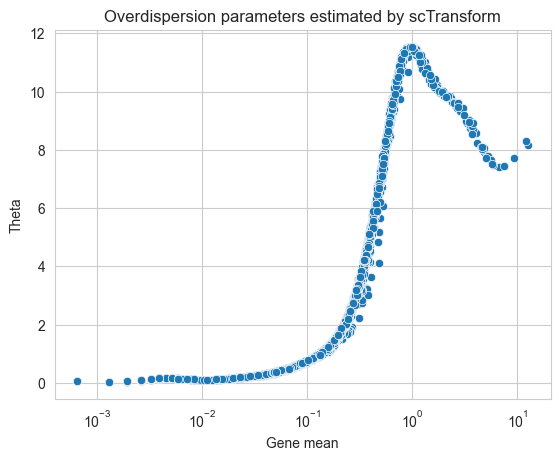

In [105]:
data_null.var["mean_counts"] = np.asarray(np.mean(data_null.X, axis=0)).squeeze()
g = sns.scatterplot(data=data_null.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

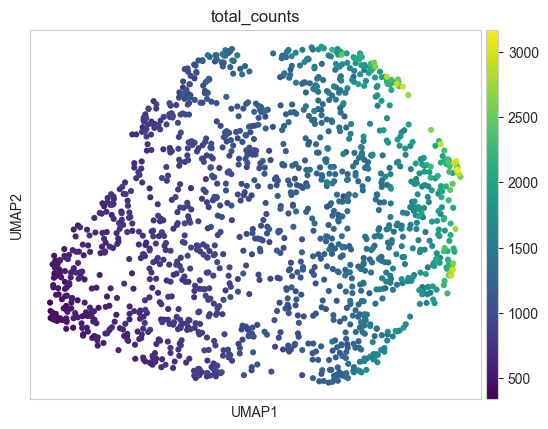

In [106]:
sc.pp.calculate_qc_metrics(data_null, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null, target_sum=None, layer=None)
data_null.X = sps.csr_matrix(np.log(data_null.X.toarray() + np.array(data_null.var["nb_overdisp_cutoff"] / 4)))
data_null.layers["vst_counts"] = data_null.X.copy()
sc.pp.scale(data_null, max_value=10, zero_center=True)
# data_gene.X[np.isnan(data_gene.X)] = 0
sc.tl.pca(data_null, svd_solver='arpack')
sc.pp.neighbors(data_null, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)
sc.pl.umap(data_null, color="total_counts", alpha=1, cmap="viridis")
plt.show()

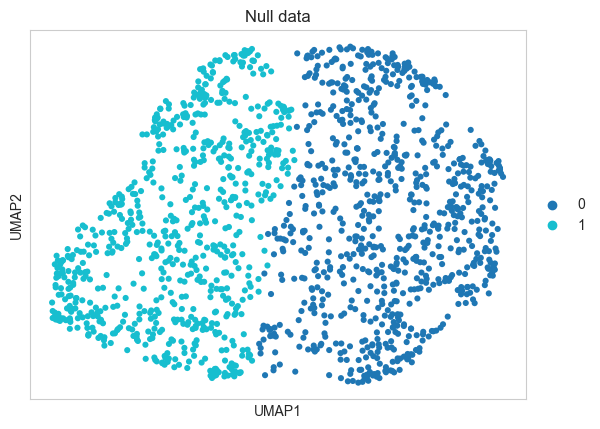

In [107]:
sc.tl.leiden(data_null, resolution=0.15, key_added="leiden", random_state=1234)
sc.pl.umap(data_null, color="leiden", palette="tab10", title="Null data")
plt.show()

In [108]:
print(data_null.var_names)
print(data_null.var)

Index(['PA0001', 'PA0002', 'PA0003', 'PA0004', 'PA0005', 'PA0006', 'PA0007',
       'PA0008', 'PA0009', 'PA0010',
       ...
       'PA5561', 'PA5562', 'PA5563', 'PA5564', 'PA5565', 'PA5566', 'PA5567',
       'PA5568', 'PA5569', 'PA5570'],
      dtype='string', length=5553)
        nb_overdisp  nb_overdisp_cutoff    nb_mean  mean_counts  \
PA0001     9.630335            9.630335  -9.900028     0.638601   
PA0002     6.079197            6.079197  -9.174755     0.450777   
PA0003    11.502777           11.502777 -10.218280     0.887306   
PA0004     4.557071            4.557071  -8.425709     0.368523   
PA0005     0.922182            0.922182  -2.518187     0.120466   
...             ...                 ...        ...          ...   
PA5566     0.114791            0.114791  -4.175684     0.013601   
PA5567     0.971709            0.971709  -2.549639     0.132124   
PA5568     9.588617            9.588617  -9.894397     0.641192   
PA5569     8.940692            8.940692 -10.665349     

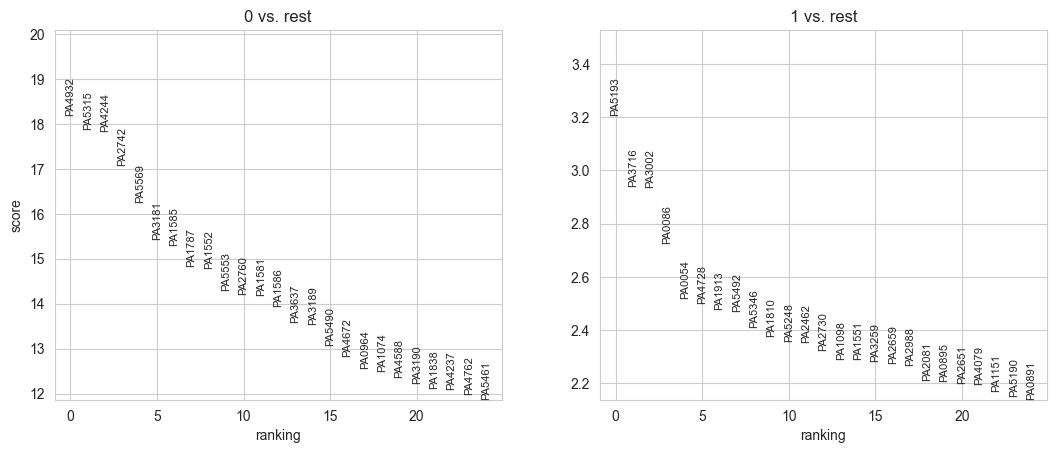

In [109]:
sc.tl.rank_genes_groups(data_null, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups(data_null, n_genes=25, sharey=False)

In [115]:
p_data = pd.DataFrame({"pval_data": [x[1] for x in data_gene.uns["rank_genes_groups"]["pvals"]]}, index = [x[1] for x in data_gene.uns["rank_genes_groups"]["names"]])
p_data

,pval_data
PA0624,3.867288e-43
PA0621,9.300020e-43
PA0629,2.140819e-42
PA0636,7.144543e-42
PA0622,1.017563e-40
...,...
PA4754,3.682723e-04
PA0937,2.954885e-04
PA4604,2.137619e-04
PA0546,1.458563e-04


In [116]:
p_null = pd.DataFrame({"pval_null": [x[1] for x in data_null.uns["rank_genes_groups"]["pvals"]]}, index = [x[1] for x in data_null.uns["rank_genes_groups"]["names"]])
p_null

,pval_null
PA5193,1.342711e-03
PA3716,3.278283e-03
PA3002,3.323333e-03
PA0086,6.468531e-03
PA0054,1.186573e-02
...,...
PA5569,2.056262e-59
PA2742,2.254447e-65
PA4244,3.904019e-71
PA5315,2.465583e-71


In [117]:
import numpy as np

In [119]:
p_table = pd.merge(p_data, p_null, left_index=True, right_index=True)
p_table["pval_data_log"] = -1*np.log10(p_table["pval_data"])
p_table["pval_null_log"] = -1*np.log10(p_table["pval_null"])
p_table["cs"] = p_table["pval_data_log"] - p_table["pval_null_log"]
p_table


,pval_data,pval_null,pval_data_log,pval_null_log,cs
PA0624,3.867288e-43,2.096147e-01,42.412594,0.678578,41.734015
PA0621,9.300020e-43,4.173043e-01,42.031516,0.379547,41.651969
PA0629,2.140819e-42,2.029240e-01,41.669420,0.692667,40.976753
PA0636,7.144543e-42,7.862021e-01,41.146026,0.104466,41.041560
PA0622,1.017563e-40,3.386141e-01,39.992439,0.470295,39.522144
...,...,...,...,...,...
PA4754,3.682723e-04,1.542083e-19,3.433831,18.811892,-15.378061
PA0937,2.954885e-04,9.486083e-09,3.529459,8.022913,-4.493454
PA4604,2.137619e-04,2.764114e-07,3.670070,6.558444,-2.888374
PA0546,1.458563e-04,3.530000e-05,3.836075,4.452225,-0.616151


<Axes: xlabel='cs', ylabel='Count'>

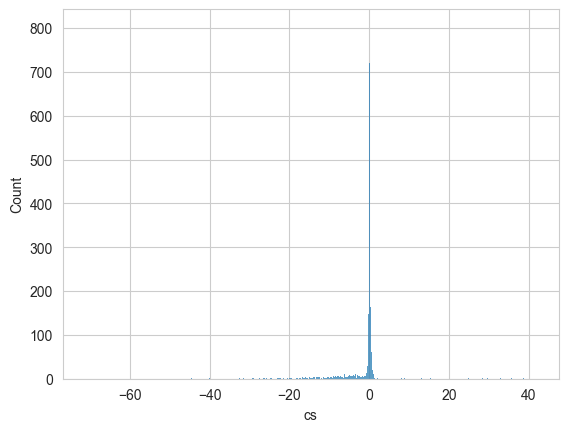

In [120]:
import seaborn as sns

sns.histplot(p_table, x="cs")

In [147]:
PairedData = rpackages.importr("PairedData")
MASS = rpackages.importr("MASS")
from rpy2.robjects import Formula

if PairedData.yuen_t_test(x = p_table["pval_data_log"], y = p_table["pval_null_log"], alternative = "greater", paired = True, tr = 0.1)["p.value"] < 0.001:
    fmla = Formula('y ~ x')
    env = fmla.environment
    env['x'] = p_table["pval_data_log"]
    env['y'] = p_table["pval_null_log"]
    fit = MASS.rlm(fmla, maxit=100)
    p_table["cs"] = fit["residuals"]
    
p_table

,pval_data,pval_null,pval_data_log,pval_null_log,cs
PA0624,3.867288e-43,2.096147e-01,42.412594,0.678578,41.734015
PA0621,9.300020e-43,4.173043e-01,42.031516,0.379547,41.651969
PA0629,2.140819e-42,2.029240e-01,41.669420,0.692667,40.976753
PA0636,7.144543e-42,7.862021e-01,41.146026,0.104466,41.041560
PA0622,1.017563e-40,3.386141e-01,39.992439,0.470295,39.522144
...,...,...,...,...,...
PA4754,3.682723e-04,1.542083e-19,3.433831,18.811892,-15.378061
PA0937,2.954885e-04,9.486083e-09,3.529459,8.022913,-4.493454
PA4604,2.137619e-04,2.764114e-07,3.670070,6.558444,-2.888374
PA0546,1.458563e-04,3.530000e-05,3.836075,4.452225,-0.616151


In [185]:
def cs2q(contrastScore, nnull = 1, threshold = "BC"):
    
    contrastScore = np.nan_to_num(contrastScore, nan=0)
    c_abs = np.abs(contrastScore[contrastScore != 0])
    c_abs = np.sort(np.unique(c_abs))
    
    i = 0
    emp_fdp = []
    
    if threshold == "BC":
        for t in c_abs:
            emp_fdp.append(np.min([(1/nnull + 1/nnull*np.sum(contrastScore <= -t))/np.sum(contrastScore > -t), 1]))
            if i !=0:
                emp_fdp[i] = np.min([emp_fdp[i], emp_fdp[i-1]])
            i += 1
    elif threshold == "DS":
        for t in c_abs:
            emp_fdp.append(np.min([(1/nnull*np.sum(contrastScore <= -t))/np.sum(contrastScore > -t), 1]))
            if i !=0:
                emp_fdp[i] = np.min([emp_fdp[i], emp_fdp[i-1]])
            i += 1
            
    emp_fdp = np.array(emp_fdp)
    
    c_abs = c_abs[~np.isnan(emp_fdp)]
    emp_fdp = emp_fdp[~np.isnan(emp_fdp)]
    
    q_ind = [np.where(c_abs == x)[0] for x in contrastScore]
    q = [emp_fdp[x[0]] if len(x) > 0 else 1 for x in q_ind]
    return q

In [187]:
p_table["q"] = cs2q(p_table["cs"])
p_table.sort_values("cs", inplace=True, ascending=False)
p_table

,pval_data,pval_null,pval_data_log,pval_null_log,cs,q
PA0624,3.867288e-43,2.096147e-01,42.412594,0.678578,41.734015,0.002527
PA0621,9.300020e-43,4.173043e-01,42.031516,0.379547,41.651969,0.002527
PA0636,7.144543e-42,7.862021e-01,41.146026,0.104466,41.041560,0.002527
PA0629,2.140819e-42,2.029240e-01,41.669420,0.692667,40.976753,0.002527
PA0622,1.017563e-40,3.386141e-01,39.992439,0.470295,39.522144,0.002889
...,...,...,...,...,...,...
PA5569,5.585471e-03,2.056262e-59,2.252940,58.686922,-56.433981,1.000000
PA2742,5.983781e-04,2.254447e-65,3.223024,64.646960,-61.423936,1.000000
PA4244,7.039360e-03,3.904019e-71,2.152467,70.408488,-68.256021,1.000000
PA5315,3.909276e-01,2.465583e-71,0.407904,70.608080,-70.200177,1.000000


In [188]:
FDR = 0.05
DEGenes = p_table[p_table["q"] < FDR]
DEGenes

,pval_data,pval_null,pval_data_log,pval_null_log,cs,q
PA0624,3.867288e-43,0.209615,42.412594,0.678578,41.734015,0.002527
PA0621,9.300020e-43,0.417304,42.031516,0.379547,41.651969,0.002527
PA0636,7.144543e-42,0.786202,41.146026,0.104466,41.041560,0.002527
PA0629,2.140819e-42,0.202924,41.669420,0.692667,40.976753,0.002527
PA0622,1.017563e-40,0.338614,39.992439,0.470295,39.522144,0.002889
PA0623,1.832160e-39,0.756770,38.737037,0.121036,38.616000,0.002889
PA0635,9.383965e-40,0.372662,39.027614,0.428684,38.598929,0.002889
PA0620,1.088969e-38,0.533250,37.962984,0.273069,37.689915,0.002889
PA0628,4.465308e-37,0.632327,36.350149,0.199058,36.151091,0.003251
PA0617,5.767893e-37,0.530211,36.238983,0.275552,35.963431,0.003251


## Reproduce tutorial dataset

In [3]:
null_p = pd.read_csv("../P_aero_S2S3/null_p.csv").T
null_p.columns=(["pval_null"])
orig_p = pd.read_csv("../P_aero_S2S3/orig_p.csv").T
orig_p.columns=(["pval_data"])

print(null_p)

                  pval_null
RPS19          6.426641e-48
LST1           3.683361e-43
VCAN           2.027199e-34
AIF1           4.535520e-34
COTL1          5.003712e-33
...                     ...
AL928768.3     1.000000e+00
LINC00944      1.000000e+00
FXYD1          1.000000e+00
CTC-523E23.11  1.000000e+00
RP11-222K16.2  1.000000e+00

[8898 rows x 1 columns]


In [4]:
import tools.ClusterDE as cd
importlib.reload(cd)
DE, pval = cd.call_de(orig_p, null_p, FDR=0.05, correct=False, nlog=True)


In [5]:
pval

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
FCGR3A,1.092484e-79,3.309725e-18,78.961585,17.480208,61.481377,0.015385
CD79B,7.181364e-54,4.846392e-01,53.143793,0.314581,52.829212,0.015385
RHOC,1.774965e-66,8.034855e-16,65.750810,15.095022,50.655788,0.015385
CDKN1C,3.106447e-68,2.420577e-18,67.507736,17.616081,49.891655,0.015385
CKB,2.766139e-45,2.053698e-01,44.558126,0.687463,43.870663,0.015385
...,...,...,...,...,...,...
RPL24,8.004818e-05,1.087804e-17,4.096649,16.963450,-12.866801,1.000000
EEF1A1,1.011525e-10,2.821982e-24,9.995024,23.549446,-13.554422,1.000000
RPL35A,1.386971e-02,6.078469e-17,1.857932,16.216206,-14.358273,1.000000
RPL28,8.531610e-04,1.904526e-18,3.068969,17.720213,-14.651244,1.000000


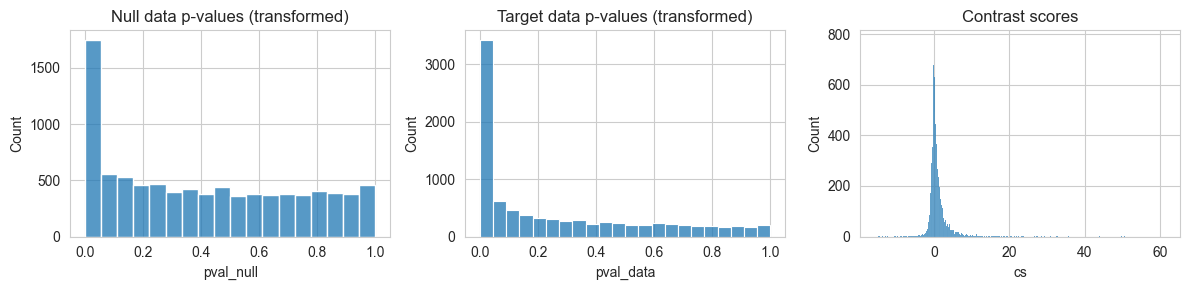

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(pval, x="pval_null", ax=ax[0])
ax[0].set_title("Null data p-values (transformed)")
sns.histplot(pval, x="pval_data", ax=ax[1])
ax[1].set_title("Target data p-values (transformed)")
sns.histplot(pval, x="cs", ax=ax[2])
ax[2].set_title("Contrast scores")
plt.tight_layout()
plt.show()